# Setup code

In [2]:
%matplotlib inline
import collections
import copy
import html
import os
import re
import shutil
import json
import glob
from functools import partial
from numpy import trapz
import csv
import pandas as pd

from datetime import datetime

from matplotlib import pyplot as plt 
import seaborn as sns 
from math import sqrt 
import pandas as pd 
import math

from IPython.core.display import display, HTML
import numpy as np 
import pandas as pd

# FIXME(sam): make cluster subpath selectable with a dropdown. Also, automatically infer
# gfs_mount from the hostname (have sensible default for svm/perceptron)

# this identifies data for a particular cluster on the GFS volume
# cluster_subpath = "with-resnet-128-2020-01-27/"
cluster_subpath = "cluster-data/cluster-2021-01-29-set3-try4/"
# on svm I think gfs_mount is /scratch/sam/repl-vol/ or something like that
# gfs_mount = "/scratch/cynthiachen/"
gfs_mount = "/scratch/sam/il-representations-gcp-volume/"  # Google Filestore mount point (local)
runs_directory = os.path.join(gfs_mount, cluster_subpath)
path_translations = {
    # when loading things like 'encoder_path' and 'policy_path' from configs,
    # replace the thing on the left with the thing on the right
    "/data/il-representations/": gfs_mount,
    "/root/il-rep/runs/": os.path.join(gfs_mount, cluster_subpath),
    "/home/sam/repos/il-representations/cloud/runs/": os.path.join(gfs_mount, cluster_subpath)
}

exp_dir = os.path.join(runs_directory, 'chain_runs')
assert os.path.exists(exp_dir)

# Preparing a table of results

In [3]:
def get_parent_relpath(sample_parent_file, local_root_dir):
    """Get root-relative path to a 'parent' directory, such as the directory
    containing a saved encoder or policy. This is somewhat tricky because
    we need to replace paths that might be different on svm/perceptron or on
    a laptop compared to what they were on GCP. e.g. inside the Ray docker
    container, '/root/il-rep/runs' maps to 'cluster-data/' in the GFS volume.
    The `path_translations` variable handles all the necessary changes."""
    for prefix, replacement in path_translations.items():
        if sample_parent_file.startswith(prefix):
            sample_parent_file = replacement + sample_parent_file[len(prefix):]

    full_path = os.path.abspath(sample_parent_file)
    full_dir = os.path.dirname(full_path)
    rel_dir = os.path.relpath(full_dir, local_root_dir)

    return rel_dir

class SubexperimentRun:
    """A SubexperimentRun associates all the information associated
    with a run of a particular Sacred sub-experiment. That means a
    run (single execution) of the 'repl', 'il_train', or 'il_test'
    experiments."""
    def __init__(self, subexp_dir, experiment_dir_root):
        # Subexperiment dir is used as a unique identifier.
        # We strip out the leading 'experiment_dir_root' to shorten identifiers.
        subexp_dir = os.path.abspath(subexp_dir)
        experiment_dir_root = os.path.abspath(experiment_dir_root)
        self.ident = os.path.relpath(subexp_dir, experiment_dir_root)
        self.subexp_dir = subexp_dir
        self.experiment_dir_root = experiment_dir_root

        # usually paths are like, e.g., 'chain_runs/repl/42' or
        # 'chain_runs/il_train/13'; if we take the second last component,
        # we should get the mode
        self.mode = os.path.split(os.path.split(subexp_dir)[0])[1]
        assert self.mode in {'repl', 'il_train', 'il_test'}, (mode, subexp_dir)

        # Load experiment config
        config_path = os.path.join(subexp_dir, 'config.json')
        with open(config_path, 'r') as fp:
            self.config = json.load(fp)

        # Store a path to relevant progress.csv file (only for il_train/repl)
        progress_path = os.path.join(subexp_dir, "progress.csv")
        if os.path.exists(progress_path):
            self.progress_path = progress_path
        else:
            self.progress_path = None

        # Store a path to relevant eval.json file
        eval_json_path = os.path.join(subexp_dir, "eval.json")
        if os.path.exists(eval_json_path):
            self.eval_json_path = eval_json_path
        else:
            self.eval_json_path = None

        # Infer the .ident attribute for the parent experiment
        # (if it exists)
        if self.mode == 'il_train' and self.config.get('encoder_path') is not None:
            encoder_relpath = get_parent_relpath(
                self.config['encoder_path'], experiment_dir_root)
            # The relpath is going to be something like
            # "chain_runs/10/repl/5/checkpoints/representation_encoder".
            # We heuristically remove the last two parts.
            # (this definitely breaks on Windows…)
            encoder_relpath = '/'.join(encoder_relpath.split('/')[:-2])
            self.parent_ident = encoder_relpath
        elif self.mode == 'il_test':
            policy_relpath = get_parent_relpath(
                self.config['policy_path'], experiment_dir_root)
            self.parent_ident = policy_relpath
        else:
            # "repl" runs and "il_train" runs without an encoder_path
            # have no parents
            assert self.mode == 'repl' \
              or (self.mode == 'il_train' and self.config.get('encoder_path') is None), \
               (self.mode, self.config.get('encoder_path'))
            self.parent_ident = None
            
        # HACK: adding a use_repl key so that we can see whether il_train runs used repL
        if self.mode == 'il_train':
            self.config['use_repl'] = self.parent_ident is not None

    def get_merged_config(self, index):
        """Get a 'merged' config dictionary for this subexperiment and
        all of its parents. The dict will have a format like this:
        
        {"benchmark": {…}, "il_train": {…}, "il_test": {…}, "repl": {…}}
        
        Note that some keys might not be present (e.g. if this is a `repl` run,
        it will not have the `il_train` key; if this is an `il_train` run with
        no parent, then the `repl` key will be absent)."""
        config = {self.mode: dict(self.config)}
        extract_keys = ('env_cfg', 'venv_opts', 'env_data')
        for extract_key in extract_keys:
            if extract_key in config[self.mode]:
                # move 'benchmark' key to the top because that ingredient name is
                # shared between il_train, and il_test experiments
                config[extract_key] = config[self.mode][extract_key]
                del config[self.mode][extract_key]
        parent = self.get_parent(index)
        if parent is not None:
            # TODO: merge this properly, erroring on incompatible duplicate
            # keys. I think Cody has code for this.
            config.update(parent.get_merged_config(index))
        return config
    
    def get_parent(self, index):
        if self.parent_ident is None:
            return None
        return index.get_subexp(self.parent_ident)

    def __hash__(self):
        return hash(self.ident)
    
    def __eq__(self, other):
        if not isinstance(other, SubexperimentRun):
            return NotImplemented
        return self.ident == other.ident

class SubexperimentIndex:
    """An index of subexperiments. For now this just supports
    looking up experiments by identifier. Later it might support
    lookup by attributes."""
    def __init__(self):
        self.subexp_by_ident = {}
        
    def add_subexp(self, subexp):
        if subexp.ident in self.subexp_by_ident:
            raise ValueError("duplicate subexperiment:", subexp)
        self.subexp_by_ident[subexp.ident] = subexp
        
    def get_subexp(self, ident):
        return self.subexp_by_ident[ident]
    
    def search(self, **attrs):
        """Find a subexperiment with attributes matching the values
        given in 'attrs'."""
        results = []
        for subexp in self.subexp_by_ident.values():
            for k, v in attrs.items():
                if getattr(subexp, k) != v:
                    break
            else:
                results.append(subexp)
        return results

def get_experiment_directories(root_dir, skip_skopt=True):
    """Look for directories that end in a sequence of numbers, and contain a
    grid_search subdirectory."""
    expt_pat = re.compile(r'^.*/(il_test|il_train|repl)/\d+$')
    ignore_pat = re.compile(r'^.*/(grid_search|_sources)$')  # ignore the grid_search subdir
    expt_dirs = set()
    for root, dirs, files in os.walk(root_dir, followlinks=True, topdown=True):
        if ignore_pat.match(root):
            del dirs[:]
            continue
            
        # check whether tihs is a skopt dir
        if skip_skopt and 'grid_search' in dirs:
            gs_files = os.listdir(os.path.join(root, 'grid_search'))
            if any(s.startswith('search-alg-') for s in gs_files):
                # this is a skopt dir, skip it
                print("skipping skopt directory in", root)
                del dirs[:]
                continue

        found_match = False
        for d in dirs:
            d_path = os.path.abspath(os.path.join(root, d))
            m = expt_pat.match(d_path)
            if m is None:
                continue  # no match
            expt_dirs.add(d_path)
            found_match = True

        if found_match:
            del dirs[:]  # don't recurse
    return sorted(expt_dirs)

# Find all experiment directories (i.e. directories containing a grid_search
# subdir)
def load_all_subexperiments(root_dir, skip_skopt=True):
    """Find all experiment run subdirectories, and create SubexperimentIndex objects for them."""
    print("Searching for experiment directories (might take a minute or two)")
    all_expt_directories = get_experiment_directories(root_dir, skip_skopt=skip_skopt)
    print("Loading experiments (might take another minute or two)")
    index = SubexperimentIndex()
    for expt_dir in all_expt_directories:
        subexp = SubexperimentRun(expt_dir, root_dir)
        index.add_subexp(subexp)
    return index

In [4]:
subexp_index = load_all_subexperiments(runs_directory, skip_skopt=True)
print('Discovered', len(subexp_index.subexp_by_ident), 'subexperiments')

test_expts = subexp_index.search(mode='il_test')

test_expts[1].get_merged_config(subexp_index)

Searching for experiment directories (might take a minute or two)
Loading experiments (might take another minute or two)
Discovered 5012 subexperiments


{'il_test': {'deterministic_policy': False,
  'device_name': 'auto',
  'exp_ident': 'icml_inv_dyn_cfg_data_repl_demos_random',
  'n_rollouts': 100,
  'policy_path': '/root/il-rep/runs/chain_runs/1/il_train/2/policy_final.pt',
  'run_id': 'test',
  'seed': 123091896,
  'torch_num_threads': 1,
  'video_file_name': 'rollouts.mp4',
  'write_video': False},
 'env_cfg': {'__doc__': 'The `env_cfg` ingredient contains all (and only) the config variables\nthat would be necessary to construct a Gym environment (*not* a vec env,\nwhich would require the additional settings from the venv_opts\ningredient). `env_cfg` is thus used by every script, including the repL\nscript, the IL training script, and the IL testing script.',
  'benchmark_name': 'magical',
  'dm_control_frame_stack': 3,
  'dm_control_full_env_names': {'ball-in-cup-catch': 'DMC-Ball-In-Cup-Catch-v0',
   'cartpole-swingup': 'DMC-Cartpole-Swingup-v0',
   'cheetah-run': 'DMC-Cheetah-Run-v0',
   'finger-spin': 'DMC-Finger-Spin-v0',
   '

## Print a table of il_test results

Shows a separate set of il_test results for each benchmark setting, and also puts that data into a dataframe

In [5]:
def flatten_dict(d):
    """Flatten a nested dict into a single-level dict with
    'keys/separated/like/this'."""
    out_dict = {}
    if isinstance(d, dict):
        key_iter = d.items()
    else:
        assert isinstance(d, list), type(d)
        # we flatten lists into dicts of the form {0: <first elem>, 1: <second elem>, …}
        key_iter = ((str(idx), v) for idx, v in enumerate(d))
    for key, value in key_iter:
        if isinstance(value, (dict, list)):
            value = flatten_dict(value)
            for subkey, subvalue in value.items():
                out_dict[f'{key}/{subkey}'] = subvalue
        else:
            out_dict[key] = value
    return out_dict

def combine_dicts_multiset(dicts):
    """Combine a series of dicts into a key-multiset mapping, where the
    multiset measures how many times each observed value occurs for each
    key."""
    count_dict = {}
    for d in dicts:
        for k, v in d.items():
            if k not in count_dict:
                count_dict[k] = collections.Counter()
            count_dict[k][v] += 1
    return count_dict

def remove_inapplicable_keys(flat_dict):
    """Remove keys that do not make a difference from a flattened config dicts.
    Totally heuristic, so might have to add more options to this later on."""
    remove_keys = set()
    
    # remove inapplicable benchmark keys
    for benchmark_name in ['magical', 'dm_control']:
        if flat_dict.get('env_cfg/benchmark_name') != benchmark_name:
            for key in flat_dict:
                # this will remove, e.g., dm_control keys from magical experiments
                if key.startswith('env_cfg/' + benchmark_name) or key.startswith('env_data/' + benchmark_name):
                    remove_keys.add(key)
                    
    # remove repl keys from things that don't use repL
    if flat_dict.get('il_train/use_repl') is False:
        for key in flat_dict:
            if key.startswith('repl/'):
                remove_keys.add(key)
                    
    return {k: v for k, v in flat_dict.items() if k not in remove_keys}

def simplify_config_dicts(hierarchical_dicts,
                          base_thresh=0.75,
                          remove_seeds=True,
                          prohibited_base_keys=('env_cfg/task_name', 'env_cfg/benchmark_name', ),
                          force_remove_keys=('il_test/policy_path', 'il_train/encoder_path')):
    """Simplify flattened config dicts so that:
    
    0. They are totally flat.
    1. They only contain keys for which values actually differ between
       different dicts, and
    2. If the value of some key is the same for at least a fraction
       `base_thresh` of dicts, then that key is moved into a _base config_.
       Returned dicts will only contain that key if they have a different
       value from the base config one.
    3. Optionally, remove all seed values from dicts.

    This makes it more clear which values are actually changing."""
    # first flatten all dicts
    dicts = [dict(flatten_dict(d)) for d in hierarchical_dicts]
    
    # remove seeds, if required
    if remove_seeds:
        for d in dicts:
            for key in list(d.keys()):
                if key.split('/')[-1] == 'seed':
                    del d[key]
                    
    # make sure that every dict has every key
    all_keys = set()
    for d in dicts:
        all_keys |= d.keys()
    for d in dicts:
        for new_key in all_keys - d.keys():
            d[new_key] = None
                    
    # remove inapplicable keys
    dicts = [remove_inapplicable_keys(d) for d in dicts]

    # now figure out which keys we wish to remove or move to the base config
    base_config = {}
    remove_keys = set()
    base_thresh_abs = len(dicts) * base_thresh
    count_dict = combine_dicts_multiset(dicts)
    for key, counter in count_dict.items():
        if len(counter) == 1 or key in force_remove_keys:
            # if all dicts have the same value for this key, we will
            # remove it from output dicts
            remove_keys.add(key)
        elif key not in prohibited_base_keys:
            # if most dicts have the same value for this key, then
            # we add it to the base config
            (max_count_item, max_count), = counter.most_common(1)
            if max_count > base_thresh_abs:
                base_config[key] = max_count_item

    # remove keys that we are ignoring, or for which the corresponding value
    # already exists in the base config
    new_dicts = []
    for old_dict in dicts:
        new_dict = {}
        for key, value in old_dict.items():
            if key in remove_keys \
              or (key in base_config and base_config[key] == value):
                continue  # skip this key
            new_dict[key] = value
        new_dicts.append(new_dict)
    
    return base_config, new_dicts

Note: the below code can take 2-3m

In [169]:
all_configs = [subexp.get_merged_config(subexp_index) for subexp in test_expts]
base_config, flat_configs = simplify_config_dicts(all_configs)
flat_config_tups = [tuple(sorted(d.items())) for d in flat_configs]
subexp_by_benchmark = {}
for flat_cfg, subexp in zip(flat_config_tups, test_expts):
    bench_key = tuple((k, v) for k, v in flat_cfg if k.startswith('env_') or k.startswith('venv_'))
    subexp_by_benchmark.setdefault(bench_key, []).append((flat_cfg, subexp))

display(HTML('<p><strong>Base config</strong></p>'))
display(HTML('<p>Unless specified otherwise, all config dicts include these keys:</p>'))
print(base_config)

raw_return_data = {}
    
for idx, (bench_key, cfgs_subexps) in enumerate(subexp_by_benchmark.items(), start=1):
    # print out benchmark details
    display(HTML(f'<p><strong>Results for benchmark config &#35;{idx}</strong></p>'))
    display(HTML(f'<p>Config:</p>'))
    rows = [f'<tr><th>{html.escape(key)}</th><td>{html.escape(value)}</td></tr>' for key, value in bench_key]
    display(HTML(f'<table>{"".join(rows)}</table>'))
    display(HTML(f'<p>Runs:</p>'))
    
    # cluster subexperiments by config
    by_cfg = {}
    for tup_cfg, subexp in cfgs_subexps:
        tup_cfg = tuple(k for k in tup_cfg if k not in bench_key)
        by_cfg.setdefault(tup_cfg, []).append(subexp)
        

    # load all eval.json files and figure out what columns we need
    stats_dicts = {}
    columns = set()
    for _, subexp in cfgs_subexps:
        if subexp.eval_json_path:
            with open(subexp.eval_json_path, 'r') as fp:
                eval_dict = json.load(fp)
            # is this a magical run?
            is_magical = 'full_data' in eval_dict.keys()
            if is_magical:
                stats_dict = {
                    '-'.join(env_dict['test_env'].split('-')[:2]): env_dict['mean_score']
                    for env_dict in eval_dict['full_data']
                }
                stats_dict['Average on all envs'] = eval_dict['return_mean']
            else:
                stats_dict = {'return_mean': eval_dict['return_mean']}
            stats_dicts[subexp] = stats_dict
            columns |= stats_dict.keys()
        else:
            stats_dicts[subexp] = {}
    columns = sorted(columns)
    
    # now produce a table with one row per config
    table_parts = ['<table>']                                         # begin table
    table_parts.append('<tr>')                                        # begin header row
    table_parts.append('<th style="border-collapse: collapse;">Config</th>')
    table_parts.extend(f'<th style="border-collapse: collapse;">{html.escape(col_name)}</th>' for col_name in columns)
    table_parts.append('</tr>')                                       # end header row

    row_indexes = []
    rows = []
    
    for cfg, subexps in sorted(by_cfg.items(), key=lambda cfg_se: dict(cfg_se[0])['il_test/exp_ident']):
        table_parts.append('<tr>')                                    # begin row

        # cell containing config
        if True:  # remove to show full config
            d = dict(cfg)
            exp_ident = d['il_test/exp_ident']
            # bench_name = d['env_cfg/benchmark_name']
            # task_name = d['env_cfg/task_name']
            # desc_str = f'{exp_ident} ({bench_name}/{task_name})'
            table_parts.append(f'<td style="border-collapse: collapse;">{html.escape(exp_ident)}</td>')
        else:
            kv_cfg = ', '.join(f'{key}={value!r}' for key, value in cfg)
            table_parts.append(f'<td style="max-width: 600px; border-collapse: collapse;">{html.escape(kv_cfg)}</td>')
        row_indexes.append(exp_ident)  
        # cells containing data
        row_values = []
        for column in columns:
            column_values = [stats_dicts[subexp][column] for subexp in subexps
                             if column in stats_dicts[subexp]]
            if not column_values:
                table_parts.append('<td style="border-collapse: collapse;">-</td>')
                row_values.append({'mean': np.nan, 'std': np.nan, 'n': np.nan})
            else:
                mean = np.mean(column_values)
                std = np.std(column_values)
                n = len(column_values)
                table_parts.append(f'<td style="border-collapse: collapse;">{mean:.3g}±{std:.1g} ({n})</td>')
                row_values.append({'mean': mean, 'std': std, 'n': n})
        rows.append(row_values)
        # cells containing values

        table_parts.append('</tr>')                                   # end row
    raw_return_data[bench_key[1][1]] = {'row_indexes': row_indexes, 'rows': rows, 'columns': columns}
    table_parts.append('</table>')                                    # end table
    display(HTML(''.join(table_parts)))

{'il_train/bc/augs': 'rotate,translate,noise', 'il_train/bc/n_batches': 20000, 'il_train/ortho_init': False, 'il_train/use_repl': True, 'repl/dataset_configs/10/env_cfg/benchmark_name': None, 'repl/dataset_configs/11/env_cfg/benchmark_name': None, 'repl/dataset_configs/15/env_cfg/task_name': None, 'repl/algo': None, 'repl/algo_params/decoder/py/type': None, 'repl/dataset_configs/13/type': None, 'repl/dataset_configs/12/type': None, 'il_train/print_policy_summary': None, 'repl/dataset_configs/12/env_cfg/benchmark_name': None, 'repl/dataset_configs/15/env_cfg/benchmark_name': None, 'repl/dataset_configs/14/type': None, 'repl/dataset_configs/8/env_cfg/benchmark_name': None, 'repl/algo_params/batch_extender/py/type': None, 'repl/algo_params/target_pair_constructor_kwargs/temporal_offset': None, 'repl/dataset_configs/11/env_cfg/task_name': None, 'repl/dataset_configs/11/type': None, 'repl/algo_params/augmenter/py/type': None, 'repl/dataset_configs/8/type': None, 'repl/dataset_configs/14/env

env_cfg/benchmark_name,magical
env_cfg/task_name,MatchRegions


Config,Average on all envs,MatchRegions-Demo,MatchRegions-TestAll,MatchRegions-TestColour,MatchRegions-TestCountPlus,MatchRegions-TestDynamics,MatchRegions-TestJitter,MatchRegions-TestLayout,MatchRegions-TestShape
ablation_control,0.499±0.008 (2),0.853±0.003 (2),0.035±0.005 (2),0.859±0.03 (2),0.0575±0.002 (2),0.716±0.01 (2),0.685±0.06 (2),0.0437±0.009 (2),0.746±0.02 (2)
ablation_icml_tceb_cfg_data_repl_random,0.468±0.03 (8),0.843±0.05 (8),0.045±0.01 (8),0.796±0.05 (8),0.0419±0.01 (8),0.665±0.05 (8),0.605±0.06 (8),0.0397±0.01 (8),0.71±0.06 (8)
ablation_icml_tcpc_momentum_cfg_data_repl_random,0.507±0.02 (10),0.865±0.06 (10),0.048±0.02 (10),0.85±0.04 (10),0.0625±0.03 (10),0.741±0.05 (10),0.675±0.04 (10),0.0432±0.03 (10),0.769±0.05 (10)
ablation_icml_tcpc_no_augs_cfg_data_repl_random,0.492±0.03 (4),0.852±0.04 (4),0.0356±0.03 (4),0.867±0.03 (4),0.0356±0.02 (4),0.724±0.07 (4),0.655±0.05 (4),0.0385±0.006 (4),0.727±0.06 (4)
actual_control_no_ortho_init_,0.475±0.03 (9),0.864±0.05 (9),0.0564±0.02 (9),0.575±0.07 (9),0.0494±0.02 (9),0.718±0.06 (9),0.694±0.06 (9),0.0552±0.03 (9),0.786±0.05 (9)
control_no_ortho_init_cfg_data_repl_demos_magical_mt,0.496±0.006 (9),0.866±0.04 (9),0.0417±0.02 (9),0.795±0.06 (9),0.0538±0.02 (9),0.746±0.04 (9),0.669±0.05 (9),0.0464±0.01 (9),0.751±0.04 (9)
control_no_ortho_init_cfg_data_repl_demos_random,0.493±0.02 (9),0.876±0.04 (9),0.0392±0.02 (9),0.769±0.04 (9),0.0592±0.03 (9),0.717±0.06 (9),0.688±0.06 (9),0.0506±0.02 (9),0.746±0.03 (9)
control_no_ortho_init_cfg_data_repl_rand_demos_magical_mt,0.489±0.02 (5),0.86±0.05 (5),0.0555±0.01 (5),0.714±0.09 (5),0.0485±0.01 (5),0.722±0.03 (5),0.681±0.04 (5),0.0545±0.01 (5),0.777±0.03 (5)
control_no_ortho_init_cfg_data_repl_random,0.496±0.04 (8),0.876±0.07 (8),0.0419±0.02 (8),0.705±0.09 (8),0.0464±0.01 (8),0.75±0.06 (8),0.736±0.07 (8),0.0553±0.02 (8),0.758±0.05 (8)
control_ortho_init_cfg_data_repl_demos_magical_mt,0.465±0.01 (9),0.859±0.03 (9),0.0467±0.02 (9),0.576±0.05 (9),0.0336±0.02 (9),0.724±0.05 (9),0.689±0.05 (9),0.0361±0.02 (9),0.753±0.03 (9)


env_cfg/benchmark_name,dm_control
env_cfg/task_name,finger-spin


Config,return_mean
control_no_ortho_init_cfg_data_repl_demos_random,616±2e+01 (3)
control_no_ortho_init_cfg_data_repl_random,623±3e+01 (9)
control_ortho_init_cfg_data_repl_demos_random,555±3e+01 (6)
control_ortho_init_cfg_data_repl_random,570±2e+01 (8)
froco_control_no_ortho_init,0.744±0.2 (5)
froco_control_ortho_init,0.774±0.5 (5)
froco_icml_ac_tcpc_cfg_data_repl_demos_random,0.83±0.08 (2)
froco_icml_ac_tcpc_cfg_data_repl_random,1.95±1 (5)
froco_icml_dynamics_cfg_data_repl_demos_random,2.92±1 (5)
froco_icml_dynamics_cfg_data_repl_random,9.45±6 (5)


env_cfg/benchmark_name,magical
env_cfg/task_name,MoveToRegion


Config,Average on all envs,MoveToRegion-Demo,MoveToRegion-TestAll,MoveToRegion-TestColour,MoveToRegion-TestDynamics,MoveToRegion-TestJitter,MoveToRegion-TestLayout
ablation_control,0.793±0 (1),1±0 (1),0.34±0 (1),1±0 (1),1±0 (1),1±0 (1),0.42±0 (1)
ablation_icml_four_tcpc_cfg_data_repl_random,0.758±0 (1),1±0 (1),0.28±0 (1),1±0 (1),1±0 (1),1±0 (1),0.27±0 (1)
ablation_icml_identity_cpc_cfg_data_repl_random,0.765±0 (1),1±0 (1),0.34±0 (1),1±0 (1),1±0 (1),1±0 (1),0.25±0 (1)
ablation_icml_tceb_cfg_data_repl_random,0.786±0.02 (11),1±0 (11),0.333±0.08 (11),1±0 (11),1±0 (11),1±0 (11),0.384±0.08 (11)
ablation_icml_tcpc_momentum_cfg_data_repl_random,0.785±0.02 (4),1±0 (4),0.353±0.05 (4),1±0 (4),1±0 (4),1±0 (4),0.355±0.05 (4)
ablation_icml_tcpc_no_augs_cfg_data_repl_random,0.769±0.01 (6),1±0 (6),0.298±0.06 (6),1±0 (6),0.998±0.004 (6),1±0 (6),0.315±0.08 (6)
ablation_icml_temporal_cpc_asym_proj_cfg_data_repl_random,0.778±0.02 (10),1±0 (10),0.331±0.05 (10),0.999±0.003 (10),1±0 (10),1±0 (10),0.338±0.07 (10)
actual_control_no_ortho_init_,0.724±0.04 (9),1±0 (9),0.202±0.05 (9),0.73±0.2 (9),1±0 (9),1±0 (9),0.41±0.07 (9)
control_no_ortho_init_cfg_data_repl_demos_magical_mt,0.774±0.008 (9),1±0 (9),0.307±0.04 (9),0.993±0.01 (9),1±0 (9),1±0 (9),0.346±0.06 (9)
control_no_ortho_init_cfg_data_repl_demos_random,0.766±0.01 (9),1±0 (9),0.277±0.07 (9),0.999±0.003 (9),1±0 (9),1±0 (9),0.322±0.04 (9)


env_cfg/benchmark_name,dm_control
env_cfg/task_name,cheetah-run


Config,return_mean
control_no_ortho_init_cfg_data_repl_demos_random,361±7e+01 (8)
control_no_ortho_init_cfg_data_repl_random,395±5e+01 (8)
control_ortho_init_cfg_data_repl_demos_random,365±3e+01 (8)
control_ortho_init_cfg_data_repl_random,327±5e+01 (8)
froco_control_no_ortho_init,48.3±2e+01 (5)
froco_control_ortho_init,37.7±7 (5)
froco_icml_ac_tcpc_cfg_data_repl_demos_random,74.3±7 (3)
froco_icml_ac_tcpc_cfg_data_repl_random,56.2±6 (5)
froco_icml_dynamics_cfg_data_repl_demos_random,83.9±1e+01 (5)
froco_icml_dynamics_cfg_data_repl_random,71.6±6 (5)


env_cfg/benchmark_name,magical
env_cfg/task_name,MoveToCorner


Config,Average on all envs,MoveToCorner-Demo,MoveToCorner-TestAll,MoveToCorner-TestColour,MoveToCorner-TestDynamics,MoveToCorner-TestJitter,MoveToCorner-TestShape
ablation_control,0.893±0 (1),0.97±0 (1),0.816±0 (1),0.94±0 (1),0.92±0 (1),0.847±0 (1),0.863±0 (1)
newbcaugs_control_ortho_init,0.92±0 (1),0.98±0 (1),0.796±0 (1),0.965±0 (1),0.971±0 (1),0.919±0 (1),0.886±0 (1)
newbcaugs_icml_dynamics_cfg_data_repl_demos_random,0.91±0 (1),0.96±0 (1),0.781±0 (1),0.97±0 (1),0.96±0 (1),0.868±0 (1),0.924±0 (1)
newbcaugs_icml_inv_dyn_cfg_data_repl_demos_magical_mt,0.915±0.04 (3),0.96±0.06 (3),0.816±0.08 (3),0.953±0.05 (3),0.922±0.02 (3),0.877±0.04 (3),0.964±0.04 (3)
newbcaugs_icml_inv_dyn_cfg_data_repl_demos_random,0.929±0 (1),0.99±0 (1),0.845±0 (1),0.97±0 (1),0.89±0 (1),0.921±0 (1),0.961±0 (1)
newbcaugs_icml_vae_cfg_data_repl_demos_magical_mt,-,-,-,-,-,-,-


In [171]:
raw_return_dataframes = dict()                                                                                                                                                                                                                                                                                                                                                            

for k in raw_return_data.keys():
    print(f"Processing task {k}")
    raw_return_dataframes[k] = dict()
    for stat in ['mean', 'std', 'n']:
        columns = raw_return_data[k]['columns']
        index = raw_return_data[k]['row_indexes']
        rows = []
        for raw_row in raw_return_data[k]['rows']: 
            rows.append([el[stat] for el in raw_row])
        try: 
            raw_return_dataframes[k][stat] = pd.DataFrame(rows, index=index, columns=columns)
        except: 
            import pdb; pdb.set_trace()

Processing task MatchRegions
Processing task finger-spin
Processing task MoveToRegion
Processing task cheetah-run
Processing task MoveToCorner


## Print + DF-ize Raw AUC Data

In [ ]:
# How many splits?
num_split = 6

# Exclude first n values in the loss list?
start_count = 3

def calculate_auc(y, dx=1):
    return trapz(y, dx=dx)
    
train_expts = subexp_index.search(mode='il_train')
all_configs = [subexp.get_merged_config(subexp_index) for subexp in train_expts]
base_config, flat_configs = simplify_config_dicts(all_configs)
flat_config_tups = [tuple(sorted(d.items())) for d in flat_configs]
subexp_by_benchmark = {}
for flat_cfg, subexp in zip(flat_config_tups, train_expts):
    bench_key = tuple((k, v) for k, v in flat_cfg if k.startswith('env_') or k.startswith('venv_'))
    subexp_by_benchmark.setdefault(bench_key, []).append((flat_cfg, subexp))

display(HTML('<p><strong>Base config</strong></p>'))
display(HTML('<p>Unless specified otherwise, all config dicts include these keys:</p>'))
print(base_config)
    
raw_auc_data = {}

for idx, (bench_key, cfgs_subexps) in enumerate(subexp_by_benchmark.items(), start=1):
    # print out benchmark details
    
    # cluster subexperiments by config
    by_cfg = {}
    for tup_cfg, subexp in cfgs_subexps:
        tup_cfg = tuple(k for k in tup_cfg if k not in bench_key)
        by_cfg.setdefault(tup_cfg, []).append(subexp)

    # load all progress files and figure out what columns we need
    stats_dicts = {}
    columns = set()
    for cfg, subexp in cfgs_subexps:
        d = dict(cfg)
        exp_ident = d['il_train/exp_ident']
        
        if subexp.progress_path:
            df = pd.read_csv(subexp.progress_path)
            full_length = 400 if d['env_cfg/benchmark_name'] == 'dm_control' else 40
            if len(df['loss']) != full_length:
                print(f'Experiment {exp_ident} only has len(loss) {len(df["loss"])}, skipping... ')
#                 break
            step_length = len(df['loss']) // num_split
            stats_dict = {}
            if len(df['loss']) < 10: 
                stats_dicts[subexp] = {}
                continue 
            for step in range(step_length, len(df['loss']), step_length):
                label = f"step {step:02d}"
                stats_dict[label] = calculate_auc(df['loss'][start_count:step])
            stats_dict[f"step {len(df['loss'])}"] = calculate_auc(df['loss'][start_count:len(df['loss'])])
            stats_dicts[subexp] = stats_dict
            columns |= stats_dict.keys()
        else:
            stats_dicts[subexp] = {}
    columns = sorted(columns)
    

    raw_auc_data[bench_key[1][1]] = dict()
    raw_auc_data[bench_key[1][1]]['columns'] = columns 
    
    row_indexes = []
    rows = []
    for cfg, subexps in sorted(by_cfg.items(), key=lambda cfg_se: dict(cfg_se[0])['il_train/exp_ident']):
        table_parts.append('<tr>')                                    # begin row

        # cell containing config
        if True:  # remove to show full config
            d = dict(cfg)
            exp_ident = d['il_train/exp_ident']
            # bench_name = d['env_cfg/benchmark_name']
            # task_name = d['env_cfg/task_name']
            # desc_str = f'{exp_ident} ({bench_name}/{task_name})'
            table_parts.append(f'<td style="border-collapse: collapse;">{html.escape(exp_ident)}</td>')
        else:
            kv_cfg = ', '.join(f'{key}={value!r}' for key, value in cfg)
            table_parts.append(f'<td style="max-width: 600px; border-collapse: collapse;">{html.escape(kv_cfg)}</td>')
            
        # cells containing data
        row_indexes.append(exp_ident)
        row = []
        for column in columns:
            column_values = [stats_dicts[subexp][column] for subexp in subexps
                             if subexp in stats_dicts.keys() and column in stats_dicts[subexp]]
            if not column_values:
                table_parts.append('<td style="border-collapse: collapse;">-</td>')
                row.append({'mean': np.nan, 'std': np.nan, 'n': np.nan})
            else:
                mean = np.mean(column_values)
                std = np.std(column_values)
                n = len(column_values)
                table_parts.append(f'<td style="border-collapse: collapse;">{mean:.3g}±{std:.1g} ({n})</td>')
                row.append({'mean': mean, 'std': std, 'n': n})
        rows.append(row)
        # cells containing values

        table_parts.append('</tr>')                                   # end row
    raw_auc_data[bench_key[1][1]]['row_indexes'] = row_indexes
    raw_auc_data[bench_key[1][1]]['rows'] = rows
    table_parts.append('</table>')                                    # end table

In [172]:
raw_auc_dataframes = dict()

for k in raw_auc_data.keys(): 
    raw_auc_dataframes[k] = dict()
    for stat in ['mean', 'std', 'n']:
        columns = raw_auc_data[k]['columns']
        index = raw_auc_data[k]['row_indexes']
        rows = []
        for raw_row in raw_auc_data[k]['rows']: 
            rows.append([el[stat] for el in raw_row])

        raw_auc_dataframes[k][stat] = pd.DataFrame(rows, index=index, columns=columns)

## Interface Check! 

In [177]:
for task in raw_auc_dataframes.keys(): 
    for stat in raw_auc_dataframes[task].keys(): 
        raw_auc_dataframes[task][stat].to_csv(f"cached_dfs/raw_auc_dataframes_{task}_{stat}.csv")

for task in raw_return_dataframes.keys(): 
    for stat in raw_return_dataframes[task].keys(): 
        raw_return_dataframes[task][stat].to_csv(f"cached_dfs/raw_return_dataframes_{task}_{stat}.csv")

print(f"These dataframes were last saved as a failsafe cache at {datetime.now()} PST")

These dataframes were last saved as a failsafe cache at 2021-02-03 13:20:13.223043 PST


At this point, the raw data is stored in dataframes: raw_auc_dataframes and raw_return_dataframes

## Make Plots

In [193]:
def clean_index_val(index, check_algo=False, check_data=False): 
    new_index = index 
    for lookup_key, lookup_val in merge_lookups.items(): 
        new_index = new_index.replace(lookup_key, lookup_val)
    return new_index 


In [194]:
def control_not_key(col, control_key): 
    if 'control' in col: 
        if col == control_key: 
            return True 
        else: 
            return False 
    else: 
        return True 
    
def should_keep_exp_ident(ident): 
    if 'froco' in ident:
        return False 
    if 'no_ortho' in ident and 'actual' not in ident: 
        return False 
    return True 

In [208]:
def check_algo_or_data(index, lookup_dict, check_algo=False, check_data=False, verbose=True, blacklist=()):
    new_index = index 
    assert sum([check_algo, check_data]) % 2 != 0, 'One of check_algo and check_data must be True'
    inner_lookup_key = 'algo_lookups' if check_algo else 'data_lookups'
    inner_lookup_dict = lookup_dict[inner_lookup_key]
    check_type = 'data' if check_data else 'algo'
    for term in blacklist: 
        if term in index: 
            if verbose: 
                print(f"Run {index} skipped due to blacklist term {term}")
            return None 
    for lookup_key, lookup_val in inner_lookup_dict.items(): 
        if lookup_key in new_index:
            new_index = lookup_val
            return new_index
    if verbose:
        print(f"Didn't find any {check_type} entries for {index}")
    return None

In [215]:
def create_pivoted_dfs(base_df_dict, ret_col_lookup, blacklist_terms, 
                      whitelist_lookups, control_idx, verbose=True): 
    data_dataframes = dict()
    for task in base_df_dict.keys():
        data_dataframes[task] = dict()
        for stat in base_df_dict[task].keys():
            dataset_list = set([check_algo_or_data(ind, whitelist_lookups, check_data=True, 
                                                   verbose=verbose, blacklist=blacklist_terms) 
                         for ind in base_df_dict[task][stat].index]) - set([None])
            ret_col = ret_col_lookup[task]
            algo_list = set([check_algo_or_data(algo, whitelist_lookups, check_algo=True, 
                                                verbose=verbose, blacklist=blacklist_terms) 
                         for algo in base_df_dict[task][stat][ret_col].index.tolist()]) - set([None])
            
            table = pd.DataFrame(np.zeros((len(algo_list), len(dataset_list))), 
                                 index=algo_list,
                                 columns=dataset_list)

            for exp_ident in base_df_dict[task][stat][ret_col].index:
                data = check_algo_or_data(exp_ident, whitelist_lookups, check_data=True, 
                                          verbose=verbose, blacklist=blacklist_terms)
                algo = check_algo_or_data(exp_ident, whitelist_lookups, check_algo=True, 
                                          verbose=verbose, blacklist=blacklist_terms)
                if data and algo:
                    if verbose: 
                        print(f"Using information from {exp_ident}, is that OK?")
                    if not math.isnan(float(base_df_dict[task][stat][ret_col][exp_ident])):
                        try: 
                            table[data][algo] = float(base_df_dict[task][stat][ret_col][exp_ident])
                        except: 
                            import pdb; pdb.set_trace()

            # Move control to top of table
            idx = [control_idx] + [i for i in table.index if i != control_idx]
            table = table.reindex(idx)
            data_dataframes[task][stat] = table
    return data_dataframes

In [198]:
def create_pooled_dfs(base_df_dict, control_idx): 
    pooled_dataframes = dict()

    for task in base_df_dict.keys():

        #create a copy of data_dataframes that I can modify 
        pooled_dataframes[task] = dict()
        for stat in base_df_dict[task].keys(): 
            pooled_dataframes[task][stat] = base_df_dict[task][stat].copy(deep=True)


        pooled_control_mean = pooled_dataframes[task]['mean'].loc[control_idx].mean()
        pooled_control_std = pooled_dataframes[task]['std'].loc[control_idx].mean()
        pooled_control_n = pooled_dataframes[task]['n'].loc[control_idx].sum()
        pooled_dataframes[task]['mean'].loc[control_idx] = pooled_control_mean
        pooled_dataframes[task]['std'].loc[control_idx] = pooled_control_std
        pooled_dataframes[task]['n'].loc[control_idx] = pooled_control_n
    return pooled_dataframes

#### Plotting Code

In [237]:
def task_return_heatmap(task, df_dict, control_key): 
    mean_df = df_dict[task]['mean']
    str_format = "{:.2f}" if task_df.loc[:].min()[0] < 1 else "{:.0f}"

    
    std_df = df_dict[task]['std']
    std_df = std_df.applymap(str_format.format)

    normed_df = mean_df - mean_df.loc[control_key]
    normed_df.index = normed_df.index.map(clean_index_val)
    
    mean_df = mean_df.applymap(str_format.format)
    text_df = pd.DataFrame()
    for col in mean_df.columns:
        text_df[col] = mean_df[col].astype(str) + '(' + std_df[col].astype(str) + ')'
    
    plt.figure(figsize=(15, 7))
    
    plt.title(f"Mean Return: {task}")
    return sns.heatmap(normed_df, annot=text_df, annot_kws={"fontsize":13},
                cmap=sns.diverging_palette(250, 10, s=60, l=45, as_cmap=True), center=0, fmt='.10')

In [ ]:
def task_auc_heatmap(task, df_dict, control_key): 
    str_format = "{:.2f}"
    task_df = df_dict[task]['mean']
    subset_df = task_df[task_df.index.map(lambda x: 'no_ortho' not in x and 
                                                    'froco' not in x and 
                                                     'actual' not in x)]
    subset_df = subset_df[subset_df.index.map(partial(control_not_key, control_key=control_key))]
    
    std_df = df_dict[task]['std']
    std_sub_df = std_df[std_df.index.map(lambda x: 'no_ortho' not in x and 
                                                    'froco' not in x and 
                                                     'actual' not in x)]
    std_sub_df = std_sub_df[std_sub_df.index.map(partial(control_not_key, control_key=control_key))]
    std_sub_df = std_sub_df.applymap(str_format.format)
        
    normed_df = subset_df - subset_df.loc[control_key]
    normed_df.index = normed_df.index.map(clean_index_val)
    
    subset_df = subset_df.applymap(str_format.format)
    text_df = pd.DataFrame()
    for col in subset_df.columns:
        text_df[col] = subset_df[col].astype(str) + '(' + std_sub_df[col].astype(str) + ')'
        
    plt.figure(figsize=(15, 7))
    sns.heatmap(normed_df, annot=text_df, annot_kws={"fontsize":13}, 
                cmap=sns.diverging_palette(10, 250, s=60, l=45, as_cmap=True), center=0, fmt='.20')
    plt.title(f"AUC: {task}")

## Baseline Plots

In [244]:
## Configs for baseline plots 
control_idx = 'Control (Ortho Init) '
blacklist_terms = ['froco', 'ablation', 'newbcaugs']
envs = ['cheetah-run', 'finger-spin', 'MatchRegions', 'MoveToRegion']


algo_lookups = {
    'inv_dyn_': "Inverse Dynamics ", 
    "ac_tcpc_": "Action Conditioned TCPC ", 
    "vae_": "VAE ", 
    "dynamics_": "Dynamics Model ",
    "control_ortho_init_": "Control (Ortho Init) ",
    "identity_cpc_": "Augmentation CPC ", 
}

data_lookups = {
    "cfg_data_repl_random": "Random Rollouts", 
    "cfg_data_repl_demos_random": "Demos & Random Rollouts", 
    "cfg_data_repl_demos_magical_mt": "Multitask Demos", 
    "cfg_data_repl_rand_demos_magical_mt": "Multitask Demos & Random Rollouts",
}
merge_lookups = {**algo_lookups, **data_lookups, 'icml_': '',}
nested_lookups = {'data_lookups': data_lookups, 'algo_lookups': algo_lookups}
    

### Return Plots

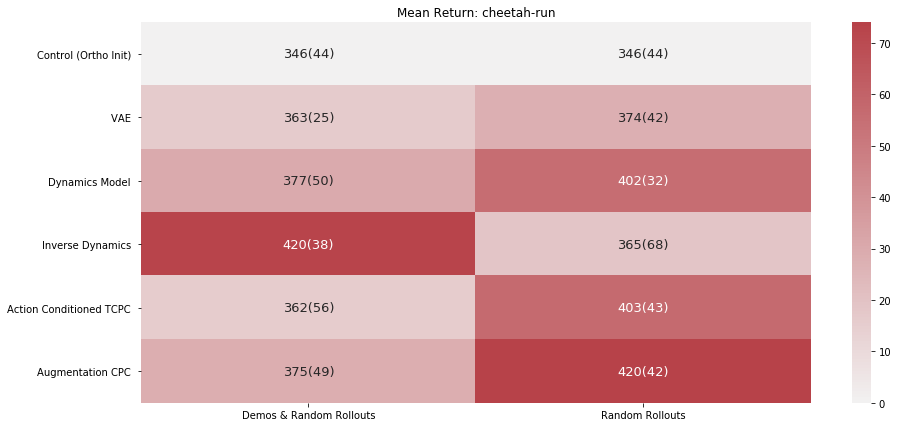

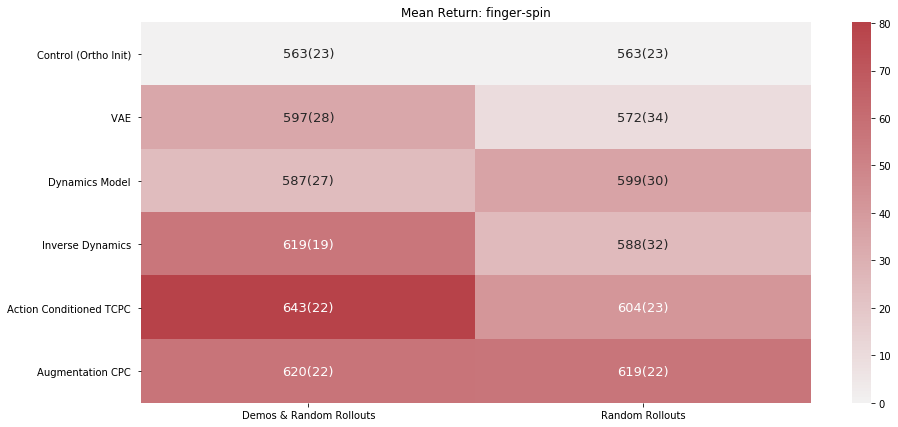

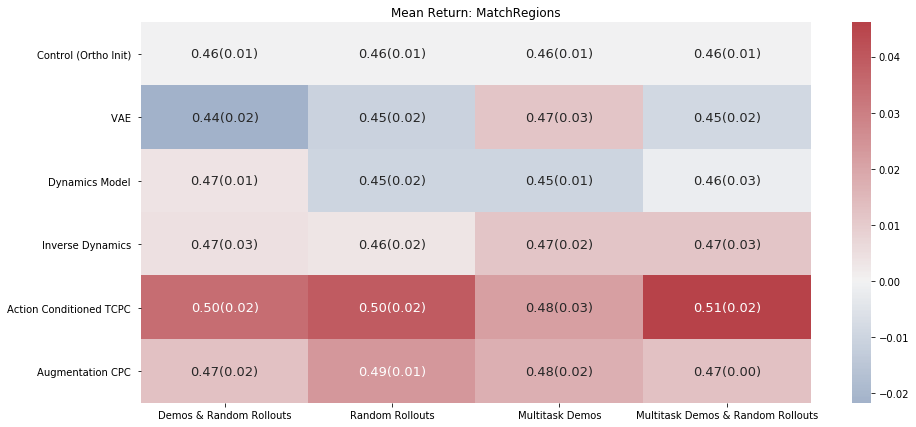

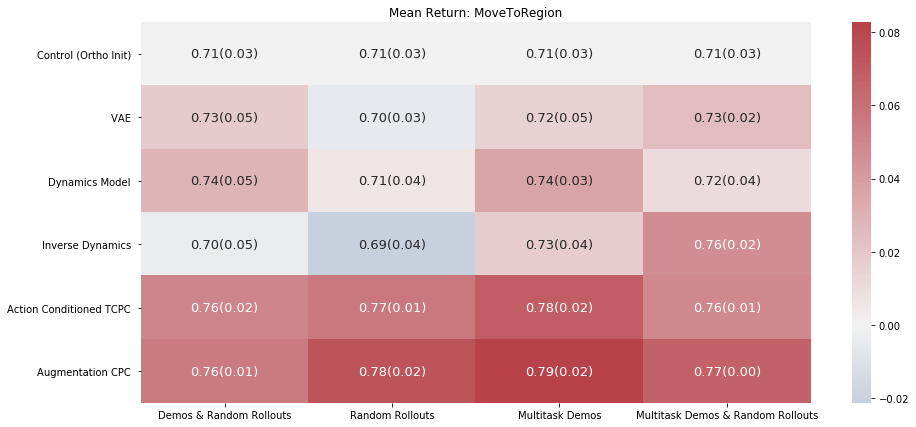

In [236]:
ret_col_lookup = {
    'MatchRegions': 'Average on all envs', 
    'MoveToRegion': 'Average on all envs', 
    'MoveToCorner': 'Average on all envs', 
    'finger-spin': 'return_mean', 
    'cheetah-run': 'return_mean'
}

pivoted_dfs = create_pivoted_dfs(raw_return_dataframes, ret_col_lookup, blacklist_terms, 
                               nested_lookups, control_idx=control_idx, verbose=False)
pooled_dfs = create_pooled_dfs(pivoted_dfs, control_idx=control_idx)


for env in envs:
    env_plot = task_heatmap(env, pooled_dfs, control_key=control_idx)
    display(env_plot)


# to be paranoid
del pivoted_dfs 
del pooled_dfs

###  AUs

None

None

None

None

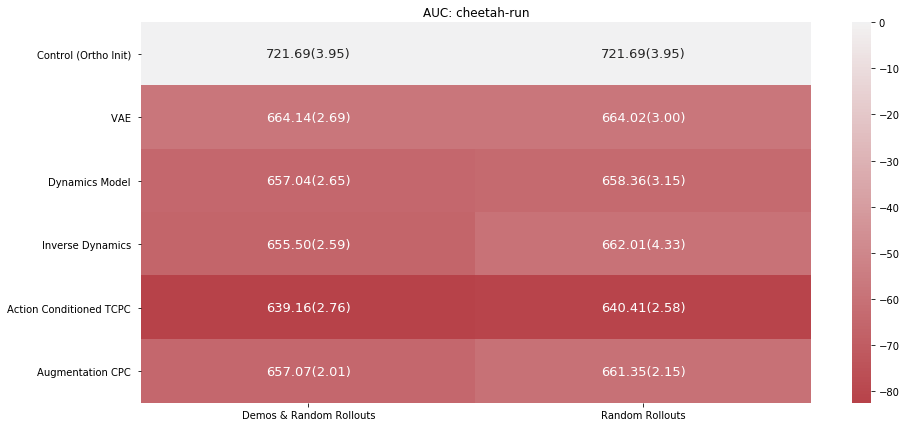

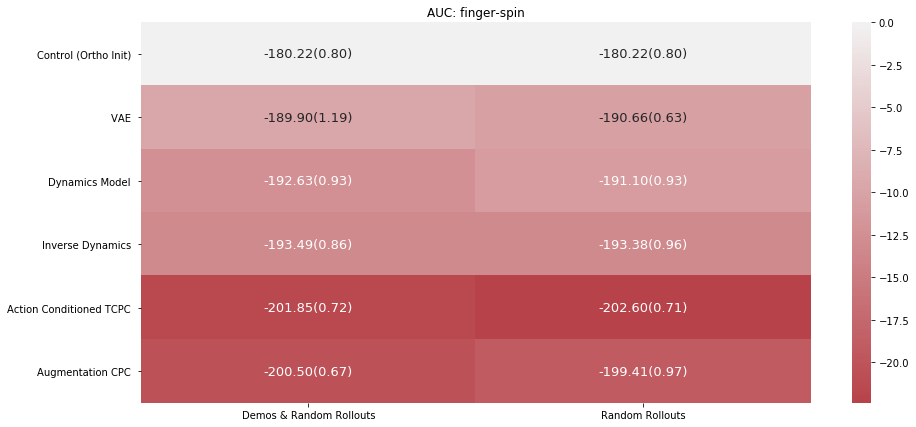

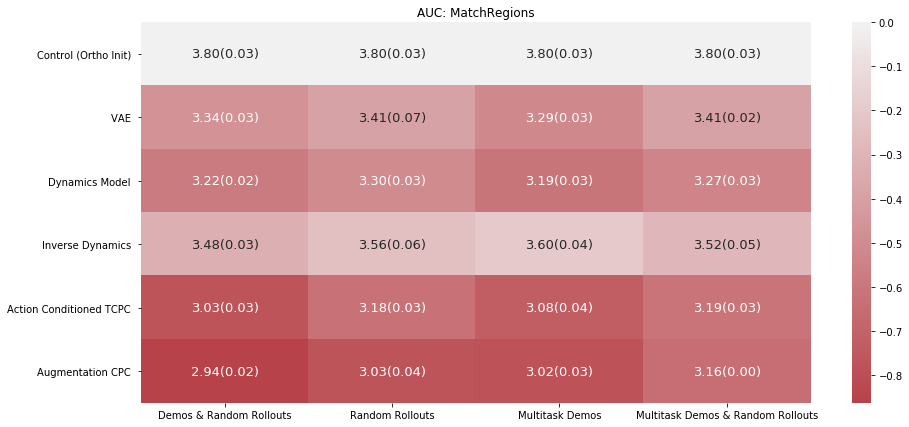

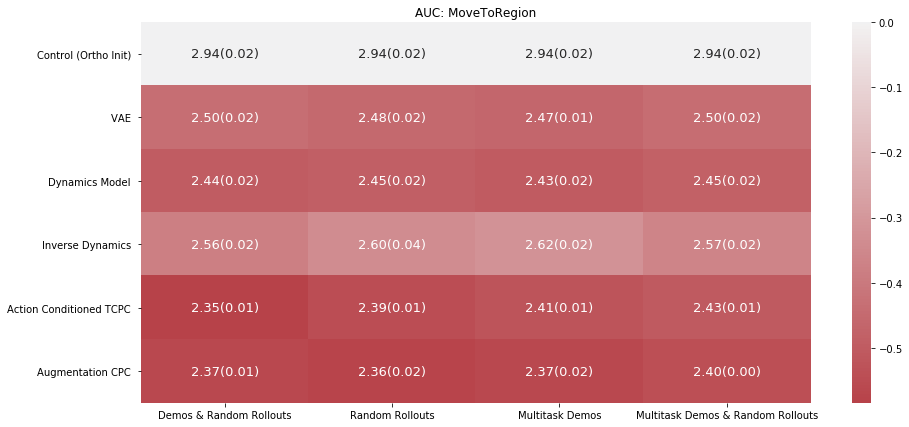

In [240]:
control_idx = 'Control (Ortho Init) '
blacklist_terms = ['froco', 'ablation', 'newbcaugs']
envs = ['cheetah-run', 'finger-spin', 'MatchRegions', 'MoveToRegion']

algo_lookups = {
    'inv_dyn_': "Inverse Dynamics ", 
    "ac_tcpc_": "Action Conditioned TCPC ", 
    "vae_": "VAE ", 
    "dynamics_": "Dynamics Model ",
    "control_ortho_init_": "Control (Ortho Init) ",
    "identity_cpc_": "Augmentation CPC ", 
}

data_lookups = {
    "cfg_data_repl_random": "Random Rollouts", 
    "cfg_data_repl_demos_random": "Demos & Random Rollouts", 
    "cfg_data_repl_demos_magical_mt": "Multitask Demos", 
    "cfg_data_repl_rand_demos_magical_mt": "Multitask Demos & Random Rollouts",
}

merge_lookups = {**algo_lookups, **data_lookups, 'icml_': '',}
nested_lookups = {'data_lookups': data_lookups, 'algo_lookups': algo_lookups}

ret_col_lookup = {
    'MatchRegions': 'step 40', 
    'MoveToRegion': 'step 40', 
    'MoveToCorner': 'step 40', 
    'finger-spin': 'step 400', 
    'cheetah-run': 'step 400'
}
    
pivoted_dfs = create_pivoted_dfs(raw_auc_dataframes, ret_col_lookup, blacklist_terms, 
                               nested_lookups, control_idx=control_idx, verbose=False)
pooled_dfs = create_pooled_dfs(pivoted_dfs, control_idx=control_idx)


for env in envs:
    env_plot = task_auc_heatmap(env, pooled_dfs, control_key=control_idx)
    display(env_plot)


# to be paranoid
del pivoted_dfs 
del pooled_dfs

# Older Code

In [ ]:
import csv
def prepare_files(index, mode, exp_index, out_dir):
    """
    Create a folder named `out_dir`. This really just copies over files from il_train or il_test, as appropriate.
    For instance, if il_train looks like this:
    
    il_train
    │   ├── 1
    │   │   ├── ...
    │   │   ├── config.json
    │   │   └── progress.csv
    │   └── _sources
    …
    
    Then the ouptut will look like this:
    ├── progress
    │   └── 1
    │       ├── params.json   (same as config.json)
    │       └── progress.csv
    …

    After you run this, you can execute viskit with: python viskit/frontend.py path/to/out_dir/
    """
    experiments = index.search(mode=mode)
    # compute merged configs (nested/hierarchical dicts), and
    # also throw out experiments with no progress.csv
    hierarchical_dicts = []
    new_experiments = []
    for experiment in experiments:
        if not experiment.progress_path:
            print("Skipping experiment", experiment.ident, "because it has no progress.csv")
            continue
        merged_config = experiment.get_merged_config(exp_index)
        hierarchical_dicts.append(merged_config)
        new_experiments.append(experiment)
    experiments = new_experiments

    # first flatten all dicts
    dicts = [dict(flatten_dict(d)) for d in hierarchical_dicts]
    
    # make sure that every dict has every key
    all_keys = set()
    for d in dicts:
        all_keys |= d.keys()
    for d in dicts:
        for new_key in all_keys - d.keys():
            d[new_key] = None
    
    # now generate outputs for experiments
    for flat_config, experiment in zip(dicts, experiments):
        exp_out_dir = os.path.join(out_dir, experiment.ident.replace('/', '-'))
        os.makedirs(exp_out_dir, exist_ok=True)

        params_json_path = os.path.join(exp_out_dir, 'params.json')
        with open(params_json_path, 'w') as fp:
            json.dump(flat_config, fp)

        progress_out_path = os.path.join(exp_out_dir, 'progress.csv')
        shutil.copyfile(experiment.progress_path, progress_out_path)
        
        if mode == 'il_test':
            eval_json_path = experiment.eval_json_path
            with open(eval_json_path, 'r') as fp:
                eval_dict = json.load(fp)
                
            result_keys, result_vals = [], []
            for key, value in eval_dict.items():
#                 print(eval_dict.keys())
                if key == 'return_mean' and value < 0.1:
                    print(eval_dict['policy_path'])
                if isinstance(value, str) or isinstance(value, int) or isinstance(value, float):
                    result_keys.append(key)
                    result_vals.append(value)
            
            with open(progress_out_path, mode='w') as result_file:
                result_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                result_writer.writerow(result_keys)
                result_writer.writerow(result_vals)

                
prepare_files(subexp_index, 'repl', subexp_index, 'viskit-repl')
prepare_files(subexp_index, 'il_train', subexp_index, 'viskit-il-train')
prepare_files(subexp_index, 'il_test', subexp_index, 'viskit-il-test')

# Plot

In [ ]:
# import matplotlib
# matplotlib.use("tkagg")
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

output_path = f"./graphs/{cluster_subpath.split('/')[1]}"
Path(output_path).mkdir(parents=True, exist_ok=True)
print(f"Images will be saved at {output_path}")

# include_ident_keywords = ['control', 'tcpc']
# exclude_ident_keywords = ['mt', 'rand_only']

include_ident_keywords = []
exclude_ident_keywords = []

def get_data(mode, data_type, include_ident_kw=None, exclude_ident_kw=None):
    assert mode in ['repl', 'il_train', 'il_test']
    assert data_type in ['loss', 'return']
    expts = subexp_index.search(mode=mode)
    all_configs = [subexp.get_merged_config(subexp_index) for subexp in expts]
    base_config, flat_configs = simplify_config_dicts(all_configs)
    flat_config_tups = [tuple(sorted(d.items())) for d in flat_configs]
    subexp_by_benchmark = {}
    for flat_cfg, subexp in zip(flat_config_tups, expts):
        bench_key = tuple((k, v) for k, v in flat_cfg if k.startswith('env_') or k.startswith('venv_'))
        subexp_by_benchmark.setdefault(bench_key, []).append((flat_cfg, subexp))
    
    """
        ret_dict has structure {'env_1': {'exp_ident_1': required_data, 'exp_ident_2': required_data, ...}, ...}
        required_data can be either a list (i.e. loss over time) or a number (int or float, like return_mean)
    """
    ret_dict = {}
    for idx, (bench_key, cfgs_subexps) in enumerate(subexp_by_benchmark.items(), start=1):
        # cluster subexperiments by config
        by_cfg = {}
        for tup_cfg, subexp in cfgs_subexps:
            tup_cfg = tuple(k for k in tup_cfg if k not in bench_key)
            by_cfg.setdefault(tup_cfg, []).append(subexp)

        task_name = bench_key[1][1]
        ret_dict[task_name] = {}
        for tup_cfg, subexp in by_cfg.items():
            exp_ident = tup_cfg[0][1]
            
            if include_ident_kw or exclude_ident_kw:
                # Find out whether we want to include this set of exp in plots or not
                include = [kw in exp_ident for kw in include_ident_kw]
                exclude = [kw in exp_ident for kw in exclude_ident_kw]
                if not True in include or True in exclude:
                    continue
                
            ret_dict[task_name][exp_ident] = []
            if data_type == 'loss':
                for exp in subexp:
                    ret_dict[task_name][exp_ident].append(pd.read_csv(subexp[0].progress_path)['loss'])
                    
            if data_type == 'return':  
                assert mode == 'il_test', 'Only test experiments have return results.'
                for exp in subexp:
                    if exp.eval_json_path:
                        eval_json_path = exp.eval_json_path
                        with open(eval_json_path, 'r') as fp:
                            eval_dict = json.load(fp)
                        is_magical = 'full_data' in eval_dict.keys()
                        if is_magical:
                            stats_dict = {
                                '-'.join(env_dict['test_env'].split('-')[:2]): env_dict['mean_score']
                                for env_dict in eval_dict['full_data']
                            }
                            stats_dict['Average on all envs'] = eval_dict['return_mean']
                        else:
                            stats_dict = {'return_mean': eval_dict['return_mean']}

                        ret_dict[task_name][exp_ident] = stats_dict
    print(ret_dict.keys())
    return ret_dict

def plot_curves(data_dict):
    sns.set(rc={'figure.figsize':(7, 6)})
    for task_key, exp_results in data_dict.items():
        df = None
        col_name = []
        plt.figure()
        for exp_ident, value, in exp_results.items():
            col_name = [f"seed_{x}" for x in range(len(value))]
            col_name += ['step', 'exp_ident']
            value.append([s for s in range(1, len(value[0])+1)])
            value.append([exp_ident for s in range(1, len(value[0])+1)])
            value = np.array(value).transpose(1, 0)
            sub_df = pd.DataFrame(data=value, columns=col_name)
            df = pd.concat([df, sub_df])
        df = pd.melt(df, id_vars=['step', 'exp_ident'])
        df['step'] = pd.to_numeric(df['step'])
        df['value'] = pd.to_numeric(df['value'])
        print(df.dtypes)
        
        ax = sns.lineplot(x='step', y='value', hue='exp_ident', data=df)
        plt.setp(ax.get_legend().get_texts(), fontsize='12')
        ax.set_title(bench_key)
        ax.savefig(os.path.join(output_path, f'{task_key}_loss.png'))

def plot_heatmap(data_dict):
    print("Generating heatmap (might need to adjust figsize for better readability)")
    print("Red = performance > control (good)")
    sns.set(rc={'figure.figsize':(10, 15)})
    for task_key, task_results in data_dict.items():
        df = pd.DataFrame.from_dict(data=task_results)
        control = df['control_no_ortho_init_cfg_data_repl_random']
        df = df.sub(control, axis='rows').T
        plt.figure()
        ax = sns.heatmap(df, annot=True, annot_kws={"fontsize":13}, center=0, cmap="vlag")
        ax.set_title(task_key)
        fig = ax.get_figure()
        fig.savefig(os.path.join(output_path, f'{task_key}_heatmap.png'))
        
    
# plot_curves(get_data('il_train', 
#                      'loss', 
#                      include_ident_kw=include_ident_keywords,
#                      exclude_ident_kw=exclude_ident_keywords))

plot_heatmap(get_data('il_test', 
                     'return', 
                     include_ident_kw=include_ident_keywords,
                     exclude_ident_kw=exclude_ident_keywords))

# Interpret encoders

Save the encoder interpretation videos. Each sub_exp might take one or two minutes to save.

In [ ]:
import glob
import subprocess
from pathlib import Path

train_expts = subexp_index.search(mode='il_test')
all_configs = [subexp.get_merged_config(subexp_index) for subexp in train_expts]
base_config, flat_configs = simplify_config_dicts(all_configs)
flat_config_tups = [tuple(sorted(d.items())) for d in flat_configs]
subexp_by_benchmark = {}
for flat_cfg, subexp in zip(flat_config_tups, train_expts):
    bench_key = tuple((k, v) for k, v in flat_cfg if k.startswith('env_') or k.startswith('venv_'))
    subexp_by_benchmark.setdefault(bench_key, []).append((flat_cfg, subexp))

# Create a folder to save videos
Path(f"./runs/{cluster_subpath.split('/')[1]}").mkdir(parents=True, exist_ok=True)
interp_algo = 'saliency'
                    
for idx, (bench_key, cfgs_subexps) in enumerate(subexp_by_benchmark.items(), start=1):
    # cluster subexperiments by config
    by_cfg = {}
    for tup_cfg, subexp in cfgs_subexps:
        tup_cfg = tuple(k for k in tup_cfg if k not in bench_key)
        by_cfg.setdefault(tup_cfg, []).append(subexp)

    for tup_cfg, subexp in by_cfg.items():
        exp = subexp[0]
        encoder_path = exp.config['encoder_path']
        if encoder_path:
            for prefix, replacement in path_translations.items():
                if encoder_path.startswith(prefix):
                    encoder_path = replacement + encoder_path[len(prefix):]
            command = "python ../src/il_representations/scripts/interpret.py with "
            command += f"log_dir=runs/{cluster_subpath.split('/')[1]} "
            command += f"env_cfg.benchmark_name={exp.config['env_cfg']['benchmark_name']} "
            command += f"env_cfg.task_name={exp.config['env_cfg']['task_name']} "
            command += f"save_video=True "
            command += f"chosen_algo={interp_algo} "
            command += f"encoder_path={encoder_path} "
            command += f"filename={exp.config['env_cfg']['task_name']}_{exp.config['exp_ident']} "

            print(f"Generating videos for exp {exp.config['exp_ident']} on {exp.config['env_cfg']['task_name']}...")
            process = subprocess.Popen(command.split(), stdout=subprocess.PIPE)
            output, error = process.communicate()